<a href="https://colab.research.google.com/github/SS-2005/MedPic_Detector/blob/main/MedicalIimagePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install tensorflow scikit-learn imbalanced-learn matplotlib opencv-python seaborn numpy pandas tqdm

In [ ]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import time
import joblib
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.mixed_precision import set_global_policy

In [ ]:
# Enable mixed precision for better memory usage and performance
set_global_policy('mixed_float16')

In [ ]:
# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ## Step 1: Data Preparation with Generators (Memory Efficient)

# %% [code]
# Constants
IMG_SIZE = (224, 224)  # Reduced size for memory efficiency
BATCH_SIZE = 64  # Larger batch size for efficiency
EPOCHS = 50
CLASS_NAMES = ['non-medical', 'medical']
DATA_DIR = "/content/drive/MyDrive/MIP/dataset"

# Function to check if an image is valid
def is_valid_image(path):
    try:
        img = tf.keras.utils.load_img(path)
        # Attempt to convert to array to catch more issues
        _ = tf.keras.utils.img_to_array(img)
        return True
    except Exception as e:
        print(f"Skipping corrupted image: {path}, error: {e}")
        return False

# Get list of all image files and filter out corrupted ones
all_image_paths = []
for root, _, files in os.walk(DATA_DIR):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            all_image_paths.append(os.path.join(root, file))

valid_image_paths = [path for path in tqdm(all_image_paths, desc="Checking images") if is_valid_image(path)]

# Create a DataFrame with image paths and labels
image_data = pd.DataFrame({'path': valid_image_paths})
image_data['label'] = image_data['path'].apply(lambda x: os.path.basename(os.path.dirname(x)))

# Split data into train and validation sets
train_df, val_df = train_test_split(image_data, test_size=0.15, random_state=SEED, stratify=image_data['label'])

# Create data generators from DataFrame
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=SEED
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=SEED
)

# Get class counts for weighting
train_labels = train_generator.classes
class_weights = {
    0: len(train_labels) / (2 * np.bincount(train_labels)[0]),
    1: len(train_labels) / (2 * np.bincount(train_labels)[1])
}

print(f"Class weights: {class_weights}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")

Checking images:  36%|███▌      | 3887/10871 [01:51<02:15, 51.44it/s]

Skipping corrupted image: /content/drive/MyDrive/MIP/dataset/medical/00005014_008.png, error: broken PNG file (chunk b'\xff\xff\xff\xff')


Checking images: 100%|██████████| 10871/10871 [03:14<00:00, 55.87it/s]


Found 9239 validated image filenames belonging to 2 classes.
Found 1631 validated image filenames belonging to 2 classes.
Class weights: {0: np.float64(0.9511015029853819), 1: np.float64(1.0541989958922866)}
Training samples: 9239
Validation samples: 1631


In [ ]:
# ## Step 2: Build Memory-Efficient Model

# %% [code]
def create_memory_efficient_model():
    # Use MobileNetV3Small for better memory efficiency
    base_model = applications.MobileNetV3Small(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )

    # Freeze base layers
    base_model.trainable = False

    # Create new model on top
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )

    return model

In [ ]:
model = create_memory_efficient_model()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 576)            │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,697 (3.58 MB)

 Trainable params: 577 (2.25 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [ ]:
# %% [markdown]
# ## Step 3: Training with Memory Optimizations

# %% [code]
# Callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    )
]

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights,  # Handle class imbalance
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5256 - auc: 0.5308 - loss: 0.7011 - precision: 0.4952 - recall: 0.4823
Epoch 1: val_accuracy improved from -inf to 0.71674, saving model to best_model.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.5258 - auc: 0.5311 - loss: 0.7010 - precision: 0.4954 - recall: 0.4828 - val_accuracy: 0.7167 - val_auc: 0.9411 - val_loss: 0.6455 - val_precision: 1.0000 - val_recall: 0.4023 - learning_rate: 0.0010
Epoch 2/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6392 - auc: 0.6882 - loss: 0.6551 - precision: 0.6264 - recall: 0.6088
Epoch 2: val_accuracy improved from 0.71674 to 0.87554, saving model to best_model.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.6393 - auc: 0.6884 - loss: 0.6550 - precision: 0.6265 - recall: 0.6091 - val_accuracy: 0.8755 - val_auc: 0.9461 - val_loss: 0.6093 - val_precision: 0.9798 - val_recall: 0.7529 - learning_rate: 0.0010
Epoch 3/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6977 - auc: 0.7681 - loss: 0.6272 - precision: 0.6857 - recall: 0.6696
Epoch 3: val_accuracy improved from 0.87554 to 0.89209, saving model to best_model.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.6977 - auc: 0.7681 - loss: 0.6271 - precision: 0.6857 - recall: 0.6696 - val_accuracy: 0.8921 - val_auc: 0.9470 - val_loss: 0.5834 - val_precision: 0.9007 - val_recall: 0.8680 - learning_rate: 0.0010
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7256 - auc: 0.8030 - loss: 0.6037 - precision: 0.7191 - recall: 0.6961
Epoch 4: val_accuracy did not improve from 0.89209
145/145 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.7256 - auc: 0.8030 - loss: 0.6037 - precision: 0.7191 - recall: 0.6961 - val_accuracy: 0.8357 - val_auc: 0.9469 - val_loss: 0.5503 - val_precision: 0.9961 - val_recall: 0.6559 - learning_rate: 0.0010
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7363 - auc: 0.8154 - loss: 0.5883 - precision: 0.7449 - recall: 0.6965
Epoch 5: val_accuracy did not improve from 0.89209
145/145 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.7364 - auc: 0.8155 - loss: 0.5883 - precision: 0.7449 - re

145/145 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.7674 - auc: 0.8479 - loss: 0.5399 - precision: 0.7749 - recall: 0.7125 - val_accuracy: 0.8939 - val_auc: 0.9493 - val_loss: 0.4870 - val_precision: 0.9425 - val_recall: 0.8266 - learning_rate: 0.0010
Epoch 9/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7747 - auc: 0.8461 - loss: 0.5348 - precision: 0.7959 - recall: 0.7097
Epoch 9: val_accuracy did not improve from 0.89393
145/145 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.7748 - auc: 0.8461 - loss: 0.5348 - precision: 0.7959 - recall: 0.7097 - val_accuracy: 0.8939 - val_auc: 0.9492 - val_loss: 0.4731 - val_precision: 0.9518 - val_recall: 0.8176 - learning_rate: 0.0010
Epoch 10/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7907 - auc: 0.8699 - loss: 0.5159 - precision: 0.8088 - recall: 0.7399
Epoch 10: val_accuracy did not improve from 0.89393
145/145 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.7906 - auc: 0.8699 - loss: 0.5159 - precision: 0.8087 - 

145/145 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.7960 - auc: 0.8690 - loss: 0.5023 - precision: 0.8276 - recall: 0.7130 - val_accuracy: 0.8952 - val_auc: 0.9505 - val_loss: 0.4505 - val_precision: 0.9263 - val_recall: 0.8461 - learning_rate: 0.0010
Epoch 13/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7863 - auc: 0.8658 - loss: 0.5010 - precision: 0.7964 - recall: 0.7437
Epoch 13: val_accuracy did not improve from 0.89516
145/145 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.7864 - auc: 0.8659 - loss: 0.5009 - precision: 0.7965 - recall: 0.7437 - val_accuracy: 0.8952 - val_auc: 0.9507 - val_loss: 0.4343 - val_precision: 0.9588 - val_recall: 0.8137 - learning_rate: 0.0010
Epoch 14/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8034 - auc: 0.8757 - loss: 0.4881 - precision: 0.8341 - recall: 0.7256
Epoch 14: val_accuracy did not improve from 0.89516
145/145 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.8034 - auc: 0.8757 - loss: 0.4881 - precision: 0.8340 

145/145 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.8025 - auc: 0.8765 - loss: 0.4785 - precision: 0.8356 - recall: 0.7280 - val_accuracy: 0.9007 - val_auc: 0.9510 - val_loss: 0.4157 - val_precision: 0.9567 - val_recall: 0.8279 - learning_rate: 0.0010
Epoch 17/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8116 - auc: 0.8863 - loss: 0.4666 - precision: 0.8344 - recall: 0.7603
Epoch 17: val_accuracy did not improve from 0.90067
145/145 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.8116 - auc: 0.8862 - loss: 0.4666 - precision: 0.8344 - recall: 0.7602 - val_accuracy: 0.8982 - val_auc: 0.9510 - val_loss: 0.4126 - val_precision: 0.9405 - val_recall: 0.8383 - learning_rate: 0.0010
Epoch 18/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8208 - auc: 0.8904 - loss: 0.4614 - precision: 0.8466 - recall: 0.7622
Epoch 18: val_accuracy did not improve from 0.90067
145/145 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.8208 - auc: 0.8904 - loss: 0.4614 - precision: 0.8466 

145/145 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.8121 - auc: 0.8799 - loss: 0.4635 - precision: 0.8416 - recall: 0.7464 - val_accuracy: 0.9019 - val_auc: 0.9519 - val_loss: 0.3947 - val_precision: 0.9527 - val_recall: 0.8344 - learning_rate: 0.0010
Epoch 21/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8120 - auc: 0.8839 - loss: 0.4583 - precision: 0.8346 - recall: 0.7500
Epoch 21: val_accuracy did not improve from 0.90190
145/145 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.8121 - auc: 0.8839 - loss: 0.4582 - precision: 0.8346 - recall: 0.7500 - val_accuracy: 0.8982 - val_auc: 0.9518 - val_loss: 0.3948 - val_precision: 0.9354 - val_recall: 0.8435 - learning_rate: 0.0010
Epoch 22/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8237 - auc: 0.8901 - loss: 0.4462 - precision: 0.8526 - recall: 0.7535
Epoch 22: val_accuracy did not improve from 0.90190
145/145 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.8237 - auc: 0.8901 - loss: 0.4462 - precision: 0.8526 

145/145 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.8279 - auc: 0.8886 - loss: 0.4463 - precision: 0.8635 - recall: 0.7510 - val_accuracy: 0.9031 - val_auc: 0.9523 - val_loss: 0.3770 - val_precision: 0.9583 - val_recall: 0.8318 - learning_rate: 0.0010
Epoch 25/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8187 - auc: 0.8964 - loss: 0.4362 - precision: 0.8466 - recall: 0.7562
Epoch 25: val_accuracy did not improve from 0.90313
145/145 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.8187 - auc: 0.8964 - loss: 0.4362 - precision: 0.8466 - recall: 0.7562 - val_accuracy: 0.9007 - val_auc: 0.9529 - val_loss: 0.3768 - val_precision: 0.9434 - val_recall: 0.8409 - learning_rate: 0.0010
Epoch 26/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8244 - auc: 0.8972 - loss: 0.4311 - precision: 0.8521 - recall: 0.7542
Epoch 26: val_accuracy did not improve from 0.90313
145/145 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.8244 - auc: 0.8972 - loss: 0.4311 - precision: 0.8521 

145/145 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.8271 - auc: 0.8986 - loss: 0.4271 - precision: 0.8625 - recall: 0.7518 - val_accuracy: 0.9037 - val_auc: 0.9533 - val_loss: 0.3636 - val_precision: 0.9570 - val_recall: 0.8344 - learning_rate: 0.0010
Epoch 29/50
 34/145 ━━━━━━━━━━━━━━━━━━━━ 2:45 1s/step - accuracy: 0.8192 - auc: 0.8888 - loss: 0.4355 - precision: 0.8658 - recall: 0.7512

KeyboardInterrupt: 

In [ ]:
# Step 4: Model Evaluation (Fixed Version)

# Define custom metrics to match those used during training
def get_custom_objects():
    return {
        'precision': tf.keras.metrics.Precision(name='precision'),
        'recall': tf.keras.metrics.Recall(name='recall'),
        'auc': tf.keras.metrics.AUC(name='auc')
    }

# Load the best model with custom objects
try:
    model = tf.keras.models.load_model('best_model.h5', custom_objects=get_custom_objects())
except:
    print("Couldn't load model with custom objects, trying without...")
    try:
        model = tf.keras.models.load_model('best_model.h5')
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Rebuilding model and loading weights instead...")
        model = create_memory_efficient_model()
        model.load_weights('best_model.h5')


Couldn't load model with custom objects, trying without...
Error loading model: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: 3.0 (of type <class 'float'>)
Rebuilding model and loading weights instead...


In [ ]:
# Create test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=SEED
)

Found 10871 images belonging to 2 classes.


In [ ]:
# Step 0: Clean the dataset of corrupted images
import os
from PIL import Image
from tqdm import tqdm

def clean_dataset(dataset_path):
    """Remove corrupted images from the dataset"""
    corrupted_count = 0
    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_dir):
            continue

        print(f"Checking {class_name} images...")
        for img_name in tqdm(os.listdir(class_dir)):
            img_path = os.path.join(class_dir, img_name)
            try:
                # Try to open and verify the image
                with Image.open(img_path) as img:
                    img.verify()  # Verify the image integrity
                # For PNGs, try converting to RGB
                if img_name.lower().endswith('.png'):
                    with Image.open(img_path) as img:
                        img.convert('RGB')
            except (IOError, SyntaxError, OSError) as e:
                print(f"Removing corrupted image: {img_path} - Error: {str(e)}")
                os.remove(img_path)
                corrupted_count += 1

    print(f"Removed {corrupted_count} corrupted images")
    return corrupted_count


In [ ]:
# Clean the dataset before proceeding
print("Cleaning dataset...")
clean_dataset(DATA_DIR)

Cleaning dataset...
Checking medical images...


 68%|██████▊   | 3890/5716 [01:51<00:37, 49.14it/s]

Removing corrupted image: /content/drive/MyDrive/MIP/dataset/medical/00005014_008.png - Error: broken PNG file (bad header checksum in b'IDAT')


100%|██████████| 5716/5716 [02:29<00:00, 38.21it/s]


Checking non-medical images...


100%|██████████| 5155/5155 [00:48<00:00, 106.24it/s]

Removed 1 corrupted images


1

In [ ]:
# Step 1: Create Robust Data Generators
class RobustImageDataGenerator(ImageDataGenerator):
    """Custom generator that skips corrupted images"""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.corrupted_count = 0

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = []
        batch_y = []
        skipped_indices = []

        for i, j in enumerate(index_array):
            try:
                # Try to load the image
                img = image_utils.load_img(
                    os.path.join(self.directory, self.filenames[j]),
                    color_mode='rgb',
                    target_size=self.target_size,
                    interpolation=self.interpolation,
                    keep_aspect_ratio=self.keep_aspect_ratio,
                )
                x = image_utils.img_to_array(img, dtype=self.dtype)
                x = self.image_data_generator.standardize(x)
                batch_x.append(x)
                batch_y.append(self.classes[j])
            except (IOError, SyntaxError, OSError) as e:
                self.corrupted_count += 1
                skipped_indices.append(j)
                continue

        # Log skipped images occasionally
        if self.corrupted_count > 0 and self.corrupted_count % 10 == 0:
            print(f"Skipped {self.corrupted_count} corrupted images so far")

        if not batch_x:
            return None, None

        return np.array(batch_x), np.array(batch_y)

In [ ]:
# Create robust generators
train_datagen = RobustImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=SEED
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=SEED
)


Found 9240 images belonging to 2 classes.
Found 1630 images belonging to 2 classes.


In [ ]:
# %% [markdown]
# ## Step 3: Training with Memory Optimizations

# %% [code]
# Callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    )
]

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights,  # Handle class imbalance
    verbose=1
)

Epoch 1/50
 34/145 ━━━━━━━━━━━━━━━━━━━━ 2:33 1s/step - accuracy: 0.8288 - auc: 0.8968 - loss: 0.4204 - precision: 0.8679 - recall: 0.7328

KeyboardInterrupt: 

In [ ]:
# Step 3: Robust Model Evaluation
def safe_model_evaluate(model, generator):
    """Evaluate model while handling corrupted images"""
    steps = generator.samples // generator.batch_size
    if generator.samples % generator.batch_size != 0:
        steps += 1

    metrics = [0] * len(model.metrics_names)
    processed_samples = 0

    generator.reset()
    for i in tqdm(range(steps)):
        try:
            batch_x, batch_y = next(generator)
            if batch_x is None:  # Skip corrupted batches
                continue

            results = model.test_on_batch(batch_x, batch_y, reset_metrics=False)
            processed_samples += len(batch_x)

            # Accumulate metrics
            for j in range(len(metrics)):
                metrics[j] += results[j] * len(batch_x)
        except Exception as e:
            print(f"Skipped batch {i} due to error: {str(e)}")
            continue

    # Finalize metrics
    for j in range(len(metrics)):
        metrics[j] /= processed_samples

    return metrics

In [ ]:
# Evaluate on test set
print("\nSafely evaluating model on test set...")
test_metrics = safe_model_evaluate(model, test_generator)

print("\nTest Metrics:")
print(f"Loss: {test_metrics[0]:.4f}")
print(f"Accuracy: {test_metrics[1]:.4f}")
print(f"Precision: {test_metrics[2]:.4f}")
print(f"Recall: {test_metrics[3]:.4f}")
print(f"AUC: {test_metrics[4]:.4f}")


Safely evaluating model on test set...


  1%|          | 1/170 [00:01<05:09,  1.83s/it]

Skipped batch 0 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  1%|          | 2/170 [00:02<04:00,  1.43s/it]

Skipped batch 1 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  2%|▏         | 3/170 [00:04<03:34,  1.29s/it]

Skipped batch 2 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  2%|▏         | 4/170 [00:05<03:24,  1.23s/it]

Skipped batch 3 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  3%|▎         | 5/170 [00:06<03:19,  1.21s/it]

Skipped batch 4 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  4%|▎         | 6/170 [00:07<03:14,  1.19s/it]

Skipped batch 5 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  4%|▍         | 7/170 [00:08<03:10,  1.17s/it]

Skipped batch 6 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  5%|▍         | 8/170 [00:09<03:07,  1.16s/it]

Skipped batch 7 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  5%|▌         | 9/170 [00:10<03:06,  1.16s/it]

Skipped batch 8 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  6%|▌         | 10/170 [00:12<03:19,  1.25s/it]

Skipped batch 9 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  6%|▋         | 11/170 [00:13<03:27,  1.30s/it]

Skipped batch 10 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  7%|▋         | 12/170 [00:15<03:19,  1.26s/it]

Skipped batch 11 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  8%|▊         | 13/170 [00:16<03:13,  1.23s/it]

Skipped batch 12 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  8%|▊         | 14/170 [00:17<03:04,  1.18s/it]

Skipped batch 13 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  9%|▉         | 15/170 [00:18<03:02,  1.17s/it]

Skipped batch 14 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  9%|▉         | 16/170 [00:19<02:58,  1.16s/it]

Skipped batch 15 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 10%|█         | 17/170 [00:20<02:56,  1.16s/it]

Skipped batch 16 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 11%|█         | 18/170 [00:21<02:56,  1.16s/it]

Skipped batch 17 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 11%|█         | 19/170 [00:22<02:53,  1.15s/it]

Skipped batch 18 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 12%|█▏        | 20/170 [00:24<02:50,  1.14s/it]

Skipped batch 19 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 12%|█▏        | 21/170 [00:25<03:04,  1.24s/it]

Skipped batch 20 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 13%|█▎        | 22/170 [00:27<03:14,  1.31s/it]

Skipped batch 21 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 14%|█▎        | 23/170 [00:28<03:10,  1.29s/it]

Skipped batch 22 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 14%|█▍        | 24/170 [00:29<03:01,  1.24s/it]

Skipped batch 23 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 15%|█▍        | 25/170 [00:30<02:53,  1.20s/it]

Skipped batch 24 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 15%|█▌        | 26/170 [00:31<02:50,  1.18s/it]

Skipped batch 25 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 16%|█▌        | 27/170 [00:32<02:47,  1.17s/it]

Skipped batch 26 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 16%|█▋        | 28/170 [00:33<02:43,  1.15s/it]

Skipped batch 27 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 17%|█▋        | 29/170 [00:35<02:41,  1.15s/it]

Skipped batch 28 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 18%|█▊        | 30/170 [00:36<02:38,  1.13s/it]

Skipped batch 29 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 18%|█▊        | 31/170 [00:37<02:35,  1.12s/it]

Skipped batch 30 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 19%|█▉        | 32/170 [00:38<02:53,  1.26s/it]

Skipped batch 31 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 19%|█▉        | 33/170 [00:40<03:03,  1.34s/it]

Skipped batch 32 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 20%|██        | 34/170 [00:41<03:01,  1.33s/it]

Skipped batch 33 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 21%|██        | 35/170 [00:42<02:52,  1.28s/it]

Skipped batch 34 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 21%|██        | 36/170 [00:43<02:45,  1.23s/it]

Skipped batch 35 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 22%|██▏       | 37/170 [00:45<02:37,  1.18s/it]

Skipped batch 36 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 22%|██▏       | 38/170 [00:46<02:34,  1.17s/it]

Skipped batch 37 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 23%|██▎       | 39/170 [00:47<02:33,  1.17s/it]

Skipped batch 38 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 24%|██▎       | 40/170 [00:48<02:31,  1.17s/it]

Skipped batch 39 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 24%|██▍       | 41/170 [00:49<02:28,  1.15s/it]

Skipped batch 40 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 25%|██▍       | 42/170 [00:50<02:28,  1.16s/it]

Skipped batch 41 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 25%|██▌       | 43/170 [00:52<02:37,  1.24s/it]

Skipped batch 42 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 26%|██▌       | 44/170 [00:53<02:49,  1.35s/it]

Skipped batch 43 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 26%|██▋       | 45/170 [00:55<02:50,  1.36s/it]

Skipped batch 44 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 27%|██▋       | 46/170 [00:56<02:40,  1.30s/it]

Skipped batch 45 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 28%|██▊       | 47/170 [00:57<02:31,  1.23s/it]

Skipped batch 46 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 28%|██▊       | 48/170 [00:58<02:27,  1.21s/it]

Skipped batch 47 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 29%|██▉       | 49/170 [00:59<02:23,  1.19s/it]

Skipped batch 48 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 29%|██▉       | 50/170 [01:00<02:21,  1.18s/it]

Skipped batch 49 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 30%|███       | 51/170 [01:01<01:53,  1.04it/s]

Skipped batch 50 due to error: [Errno 2] No such file or directory: '/content/drive/MyDrive/MIP/dataset/medical/00005014_008.png'


 31%|███       | 52/170 [01:02<01:56,  1.01it/s]

Skipped batch 51 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 31%|███       | 53/170 [01:03<02:00,  1.03s/it]

Skipped batch 52 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 32%|███▏      | 54/170 [01:04<02:04,  1.07s/it]

Skipped batch 53 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 32%|███▏      | 55/170 [01:06<02:17,  1.20s/it]

Skipped batch 54 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 33%|███▎      | 56/170 [01:07<02:27,  1.30s/it]

Skipped batch 55 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 34%|███▎      | 57/170 [01:08<02:24,  1.28s/it]

Skipped batch 56 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 34%|███▍      | 58/170 [01:10<02:19,  1.24s/it]

Skipped batch 57 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 35%|███▍      | 59/170 [01:11<02:13,  1.20s/it]

Skipped batch 58 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 35%|███▌      | 60/170 [01:12<02:10,  1.19s/it]

Skipped batch 59 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 36%|███▌      | 61/170 [01:13<02:06,  1.17s/it]

Skipped batch 60 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 36%|███▋      | 62/170 [01:14<02:04,  1.15s/it]

Skipped batch 61 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 37%|███▋      | 63/170 [01:15<02:01,  1.14s/it]

Skipped batch 62 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 38%|███▊      | 64/170 [01:16<02:01,  1.15s/it]

Skipped batch 63 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 38%|███▊      | 65/170 [01:18<02:00,  1.15s/it]

Skipped batch 64 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 39%|███▉      | 66/170 [01:19<02:11,  1.26s/it]

Skipped batch 65 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 39%|███▉      | 67/170 [01:20<02:15,  1.32s/it]

Skipped batch 66 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 40%|████      | 68/170 [01:22<02:13,  1.31s/it]

Skipped batch 67 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 41%|████      | 69/170 [01:23<02:06,  1.25s/it]

Skipped batch 68 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 41%|████      | 70/170 [01:24<02:01,  1.21s/it]

Skipped batch 69 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 42%|████▏     | 71/170 [01:25<01:56,  1.18s/it]

Skipped batch 70 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 42%|████▏     | 72/170 [01:26<01:54,  1.17s/it]

Skipped batch 71 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 43%|████▎     | 73/170 [01:27<01:52,  1.16s/it]

Skipped batch 72 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 44%|████▎     | 74/170 [01:29<01:50,  1.15s/it]

Skipped batch 73 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 44%|████▍     | 75/170 [01:29<01:37,  1.03s/it]

Skipped batch 74 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 45%|████▍     | 76/170 [01:30<01:15,  1.24it/s]

Skipped batch 75 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 45%|████▌     | 77/170 [01:30<00:59,  1.55it/s]

Skipped batch 76 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 46%|████▌     | 78/170 [01:30<00:48,  1.89it/s]

Skipped batch 77 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 46%|████▋     | 79/170 [01:30<00:40,  2.24it/s]

Skipped batch 78 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 47%|████▋     | 80/170 [01:31<00:35,  2.54it/s]

Skipped batch 79 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 48%|████▊     | 81/170 [01:31<00:31,  2.81it/s]

Skipped batch 80 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 48%|████▊     | 82/170 [01:31<00:30,  2.90it/s]

Skipped batch 81 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 49%|████▉     | 83/170 [01:32<00:29,  2.97it/s]

Skipped batch 82 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 49%|████▉     | 84/170 [01:32<00:28,  3.03it/s]

Skipped batch 83 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 50%|█████     | 85/170 [01:32<00:27,  3.07it/s]

Skipped batch 84 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 51%|█████     | 86/170 [01:32<00:27,  3.08it/s]

Skipped batch 85 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 51%|█████     | 87/170 [01:33<00:26,  3.08it/s]

Skipped batch 86 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 52%|█████▏    | 88/170 [01:33<00:26,  3.11it/s]

Skipped batch 87 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 52%|█████▏    | 89/170 [01:33<00:26,  3.11it/s]

Skipped batch 88 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 53%|█████▎    | 90/170 [01:34<00:30,  2.59it/s]

Skipped batch 89 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 54%|█████▎    | 91/170 [01:35<00:35,  2.25it/s]

Skipped batch 90 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 54%|█████▍    | 92/170 [01:35<00:36,  2.14it/s]

Skipped batch 91 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 55%|█████▍    | 93/170 [01:36<00:36,  2.10it/s]

Skipped batch 92 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 55%|█████▌    | 94/170 [01:36<00:37,  2.05it/s]

Skipped batch 93 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 56%|█████▌    | 95/170 [01:37<00:37,  1.99it/s]

Skipped batch 94 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 56%|█████▋    | 96/170 [01:37<00:37,  1.96it/s]

Skipped batch 95 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 57%|█████▋    | 97/170 [01:38<00:38,  1.92it/s]

Skipped batch 96 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 58%|█████▊    | 98/170 [01:38<00:38,  1.88it/s]

Skipped batch 97 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 58%|█████▊    | 99/170 [01:39<00:38,  1.82it/s]

Skipped batch 98 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 59%|█████▉    | 100/170 [01:39<00:38,  1.81it/s]

Skipped batch 99 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 59%|█████▉    | 101/170 [01:40<00:37,  1.84it/s]

Skipped batch 100 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 60%|██████    | 102/170 [01:40<00:36,  1.86it/s]

Skipped batch 101 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 61%|██████    | 103/170 [01:41<00:36,  1.86it/s]

Skipped batch 102 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 61%|██████    | 104/170 [01:41<00:35,  1.88it/s]

Skipped batch 103 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 62%|██████▏   | 105/170 [01:42<00:35,  1.81it/s]

Skipped batch 104 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 62%|██████▏   | 106/170 [01:43<00:35,  1.79it/s]

Skipped batch 105 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 63%|██████▎   | 107/170 [01:43<00:35,  1.80it/s]

Skipped batch 106 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 64%|██████▎   | 108/170 [01:44<00:34,  1.82it/s]

Skipped batch 107 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 64%|██████▍   | 109/170 [01:44<00:33,  1.81it/s]

Skipped batch 108 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 65%|██████▍   | 110/170 [01:45<00:34,  1.73it/s]

Skipped batch 109 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 65%|██████▌   | 111/170 [01:46<00:36,  1.63it/s]

Skipped batch 110 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 66%|██████▌   | 112/170 [01:46<00:36,  1.58it/s]

Skipped batch 111 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 66%|██████▋   | 113/170 [01:47<00:36,  1.58it/s]

Skipped batch 112 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 67%|██████▋   | 114/170 [01:48<00:36,  1.55it/s]

Skipped batch 113 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 68%|██████▊   | 115/170 [01:48<00:32,  1.67it/s]

Skipped batch 114 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 68%|██████▊   | 116/170 [01:49<00:31,  1.73it/s]

Skipped batch 115 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 69%|██████▉   | 117/170 [01:49<00:30,  1.73it/s]

Skipped batch 116 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 69%|██████▉   | 118/170 [01:50<00:29,  1.76it/s]

Skipped batch 117 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 70%|███████   | 119/170 [01:50<00:28,  1.82it/s]

Skipped batch 118 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 71%|███████   | 120/170 [01:51<00:27,  1.84it/s]

Skipped batch 119 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 71%|███████   | 121/170 [01:51<00:26,  1.85it/s]

Skipped batch 120 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 72%|███████▏  | 122/170 [01:52<00:25,  1.86it/s]

Skipped batch 121 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 72%|███████▏  | 123/170 [01:52<00:25,  1.87it/s]

Skipped batch 122 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 73%|███████▎  | 124/170 [01:53<00:24,  1.88it/s]

Skipped batch 123 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 74%|███████▎  | 125/170 [01:53<00:23,  1.92it/s]

Skipped batch 124 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 74%|███████▍  | 126/170 [01:54<00:22,  1.96it/s]

Skipped batch 125 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 75%|███████▍  | 127/170 [01:54<00:21,  1.97it/s]

Skipped batch 126 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 75%|███████▌  | 128/170 [01:55<00:21,  1.95it/s]

Skipped batch 127 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 76%|███████▌  | 129/170 [01:55<00:21,  1.91it/s]

Skipped batch 128 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 76%|███████▋  | 130/170 [01:56<00:21,  1.90it/s]

Skipped batch 129 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 77%|███████▋  | 131/170 [01:57<00:20,  1.91it/s]

Skipped batch 130 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 78%|███████▊  | 132/170 [01:57<00:20,  1.89it/s]

Skipped batch 131 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 78%|███████▊  | 133/170 [01:58<00:20,  1.80it/s]

Skipped batch 132 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 79%|███████▉  | 134/170 [01:59<00:23,  1.55it/s]

Skipped batch 133 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 79%|███████▉  | 135/170 [01:59<00:23,  1.47it/s]

Skipped batch 134 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 80%|████████  | 136/170 [02:00<00:24,  1.41it/s]

Skipped batch 135 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 81%|████████  | 137/170 [02:01<00:24,  1.35it/s]

Skipped batch 136 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 81%|████████  | 138/170 [02:02<00:23,  1.38it/s]

Skipped batch 137 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 82%|████████▏ | 139/170 [02:02<00:22,  1.37it/s]

Skipped batch 138 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 82%|████████▏ | 140/170 [02:03<00:22,  1.31it/s]

Skipped batch 139 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 83%|████████▎ | 141/170 [02:04<00:20,  1.39it/s]

Skipped batch 140 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 84%|████████▎ | 142/170 [02:04<00:18,  1.50it/s]

Skipped batch 141 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 84%|████████▍ | 143/170 [02:05<00:16,  1.62it/s]

Skipped batch 142 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 85%|████████▍ | 144/170 [02:05<00:15,  1.71it/s]

Skipped batch 143 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 85%|████████▌ | 145/170 [02:06<00:14,  1.77it/s]

Skipped batch 144 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 86%|████████▌ | 146/170 [02:06<00:13,  1.82it/s]

Skipped batch 145 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 86%|████████▋ | 147/170 [02:07<00:12,  1.83it/s]

Skipped batch 146 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 87%|████████▋ | 148/170 [02:07<00:11,  1.87it/s]

Skipped batch 147 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 88%|████████▊ | 149/170 [02:08<00:11,  1.86it/s]

Skipped batch 148 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 88%|████████▊ | 150/170 [02:09<00:10,  1.85it/s]

Skipped batch 149 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 89%|████████▉ | 151/170 [02:09<00:10,  1.87it/s]

Skipped batch 150 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 89%|████████▉ | 152/170 [02:10<00:09,  1.89it/s]

Skipped batch 151 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 90%|█████████ | 153/170 [02:10<00:08,  2.01it/s]

Skipped batch 152 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 91%|█████████ | 154/170 [02:10<00:07,  2.14it/s]

Skipped batch 153 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 91%|█████████ | 155/170 [02:11<00:06,  2.46it/s]

Skipped batch 154 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 92%|█████████▏| 156/170 [02:11<00:05,  2.66it/s]

Skipped batch 155 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 92%|█████████▏| 157/170 [02:11<00:04,  2.77it/s]

Skipped batch 156 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 93%|█████████▎| 158/170 [02:12<00:03,  3.01it/s]

Skipped batch 157 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 94%|█████████▎| 159/170 [02:12<00:03,  3.09it/s]

Skipped batch 158 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 94%|█████████▍| 160/170 [02:12<00:03,  3.16it/s]

Skipped batch 159 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 95%|█████████▍| 161/170 [02:12<00:02,  3.17it/s]

Skipped batch 160 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 95%|█████████▌| 162/170 [02:13<00:02,  3.25it/s]

Skipped batch 161 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 96%|█████████▌| 163/170 [02:13<00:02,  3.41it/s]

Skipped batch 162 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 96%|█████████▋| 164/170 [02:13<00:01,  3.53it/s]

Skipped batch 163 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 97%|█████████▋| 165/170 [02:14<00:01,  3.48it/s]

Skipped batch 164 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 98%|█████████▊| 166/170 [02:14<00:01,  3.53it/s]

Skipped batch 165 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 98%|█████████▊| 167/170 [02:14<00:00,  3.32it/s]

Skipped batch 166 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 99%|█████████▉| 168/170 [02:14<00:00,  3.31it/s]

Skipped batch 167 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 99%|█████████▉| 169/170 [02:15<00:00,  3.23it/s]

Skipped batch 168 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


100%|██████████| 170/170 [02:15<00:00,  1.25it/s]

Skipped batch 169 due to error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


ZeroDivisionError: division by zero


Safely evaluating model on test set...


  1%|          | 1/170 [00:01<04:18,  1.53s/it]

Skipped batch 0 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  1%|          | 2/170 [00:02<03:53,  1.39s/it]

Skipped batch 1 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  2%|▏         | 3/170 [00:03<03:29,  1.25s/it]

Skipped batch 2 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  2%|▏         | 4/170 [00:05<03:20,  1.21s/it]

Skipped batch 3 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  3%|▎         | 5/170 [00:06<03:18,  1.20s/it]

Skipped batch 4 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  4%|▎         | 6/170 [00:07<03:13,  1.18s/it]

Skipped batch 5 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  4%|▍         | 7/170 [00:08<03:08,  1.15s/it]

Skipped batch 6 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  5%|▍         | 8/170 [00:09<03:05,  1.14s/it]

Skipped batch 7 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  5%|▌         | 9/170 [00:10<03:01,  1.12s/it]

Skipped batch 8 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  6%|▌         | 10/170 [00:11<02:56,  1.11s/it]

Skipped batch 9 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  6%|▋         | 11/170 [00:13<03:03,  1.15s/it]

Skipped batch 10 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  7%|▋         | 12/170 [00:14<03:13,  1.22s/it]

Skipped batch 11 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  8%|▊         | 13/170 [00:15<03:23,  1.30s/it]

Skipped batch 12 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  8%|▊         | 14/170 [00:16<03:12,  1.24s/it]

Skipped batch 13 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  9%|▉         | 15/170 [00:18<03:07,  1.21s/it]

Skipped batch 14 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


  9%|▉         | 16/170 [00:19<03:03,  1.19s/it]

Skipped batch 15 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 10%|█         | 17/170 [00:20<02:59,  1.17s/it]

Skipped batch 16 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 11%|█         | 18/170 [00:21<02:55,  1.16s/it]

Skipped batch 17 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 11%|█         | 19/170 [00:22<02:53,  1.15s/it]

Skipped batch 18 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 12%|█▏        | 20/170 [00:23<02:50,  1.14s/it]

Skipped batch 19 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 12%|█▏        | 21/170 [00:24<02:50,  1.14s/it]

Skipped batch 20 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 13%|█▎        | 22/170 [00:26<02:55,  1.19s/it]

Skipped batch 21 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 14%|█▎        | 23/170 [00:27<03:08,  1.28s/it]

Skipped batch 22 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 14%|█▍        | 24/170 [00:29<03:14,  1.33s/it]

Skipped batch 23 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 15%|█▍        | 25/170 [00:30<03:03,  1.26s/it]

Skipped batch 24 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 15%|█▌        | 26/170 [00:31<02:56,  1.23s/it]

Skipped batch 25 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 16%|█▌        | 27/170 [00:32<02:51,  1.20s/it]

Skipped batch 26 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 16%|█▋        | 28/170 [00:33<02:45,  1.17s/it]

Skipped batch 27 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 17%|█▋        | 29/170 [00:34<02:42,  1.15s/it]

Skipped batch 28 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 18%|█▊        | 30/170 [00:35<02:39,  1.14s/it]

Skipped batch 29 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 18%|█▊        | 31/170 [00:36<02:37,  1.13s/it]

Skipped batch 30 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 19%|█▉        | 32/170 [00:38<02:37,  1.14s/it]

Skipped batch 31 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 19%|█▉        | 33/170 [00:39<02:41,  1.18s/it]

Skipped batch 32 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 20%|██        | 34/170 [00:40<02:54,  1.28s/it]

Skipped batch 33 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 21%|██        | 35/170 [00:42<03:02,  1.36s/it]

Skipped batch 34 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 21%|██        | 36/170 [00:43<02:52,  1.29s/it]

Skipped batch 35 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 22%|██▏       | 37/170 [00:44<02:42,  1.22s/it]

Skipped batch 36 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 22%|██▏       | 38/170 [00:45<02:40,  1.22s/it]

Skipped batch 37 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 23%|██▎       | 39/170 [00:46<02:37,  1.20s/it]

Skipped batch 38 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 24%|██▎       | 40/170 [00:48<02:34,  1.19s/it]

Skipped batch 39 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 24%|██▍       | 41/170 [00:49<02:30,  1.17s/it]

Skipped batch 40 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 25%|██▍       | 42/170 [00:51<03:08,  1.47s/it]

Skipped batch 41 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 25%|██▌       | 43/170 [00:53<03:21,  1.59s/it]

Skipped batch 42 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 26%|██▌       | 44/170 [00:54<03:18,  1.58s/it]

Skipped batch 43 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 26%|██▋       | 45/170 [00:56<03:11,  1.53s/it]

Skipped batch 44 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 27%|██▋       | 46/170 [00:57<02:54,  1.41s/it]

Skipped batch 45 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 28%|██▊       | 47/170 [00:58<02:42,  1.32s/it]

Skipped batch 46 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 28%|██▊       | 48/170 [00:59<02:31,  1.24s/it]

Skipped batch 47 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 29%|██▉       | 49/170 [01:00<02:25,  1.20s/it]

Skipped batch 48 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 29%|██▉       | 50/170 [01:01<02:21,  1.18s/it]

Skipped batch 49 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 30%|███       | 51/170 [01:02<01:53,  1.05it/s]

Skipped batch 50 due to image error: [Errno 2] No such file or directory: '/content/drive/MyDrive/MIP/dataset/medical/00005014_008.png'


 31%|███       | 52/170 [01:03<01:56,  1.01it/s]

Skipped batch 51 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 31%|███       | 53/170 [01:04<02:00,  1.03s/it]

Skipped batch 52 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 32%|███▏      | 54/170 [01:05<02:02,  1.05s/it]

Skipped batch 53 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 32%|███▏      | 55/170 [01:06<02:13,  1.16s/it]

Skipped batch 54 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 33%|███▎      | 56/170 [01:08<02:23,  1.26s/it]

Skipped batch 55 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 34%|███▎      | 57/170 [01:09<02:26,  1.30s/it]

Skipped batch 56 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 34%|███▍      | 58/170 [01:10<02:18,  1.24s/it]

Skipped batch 57 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 35%|███▍      | 59/170 [01:12<02:12,  1.19s/it]

Skipped batch 58 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 35%|███▌      | 60/170 [01:13<02:08,  1.17s/it]

Skipped batch 59 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 36%|███▌      | 61/170 [01:14<02:05,  1.15s/it]

Skipped batch 60 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 36%|███▋      | 62/170 [01:15<02:04,  1.15s/it]

Skipped batch 61 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 37%|███▋      | 63/170 [01:16<02:01,  1.14s/it]

Skipped batch 62 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 38%|███▊      | 64/170 [01:17<02:01,  1.15s/it]

Skipped batch 63 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 38%|███▊      | 65/170 [01:18<02:01,  1.16s/it]

Skipped batch 64 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 39%|███▉      | 66/170 [01:20<02:07,  1.23s/it]

Skipped batch 65 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 39%|███▉      | 67/170 [01:21<02:14,  1.30s/it]

Skipped batch 66 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 40%|████      | 68/170 [01:23<02:15,  1.33s/it]

Skipped batch 67 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 41%|████      | 69/170 [01:24<02:06,  1.26s/it]

Skipped batch 68 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 41%|████      | 70/170 [01:25<02:02,  1.22s/it]

Skipped batch 69 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 42%|████▏     | 71/170 [01:26<01:57,  1.19s/it]

Skipped batch 70 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 42%|████▏     | 72/170 [01:27<01:54,  1.17s/it]

Skipped batch 71 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 43%|████▎     | 73/170 [01:28<01:52,  1.16s/it]

Skipped batch 72 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 44%|████▎     | 74/170 [01:29<01:50,  1.15s/it]

Skipped batch 73 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 44%|████▍     | 75/170 [01:30<01:37,  1.03s/it]

Skipped batch 74 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 45%|████▍     | 76/170 [01:30<01:15,  1.25it/s]

Skipped batch 75 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 45%|████▌     | 77/170 [01:31<00:59,  1.56it/s]

Skipped batch 76 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 46%|████▌     | 78/170 [01:31<00:48,  1.90it/s]

Skipped batch 77 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 46%|████▋     | 79/170 [01:31<00:40,  2.23it/s]

Skipped batch 78 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 47%|████▋     | 80/170 [01:31<00:35,  2.55it/s]

Skipped batch 79 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 48%|████▊     | 81/170 [01:32<00:31,  2.87it/s]

Skipped batch 80 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 48%|████▊     | 82/170 [01:32<00:28,  3.12it/s]

Skipped batch 81 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 49%|████▉     | 83/170 [01:32<00:27,  3.19it/s]

Skipped batch 82 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 49%|████▉     | 84/170 [01:33<00:26,  3.19it/s]

Skipped batch 83 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 50%|█████     | 85/170 [01:33<00:26,  3.22it/s]

Skipped batch 84 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 51%|█████     | 86/170 [01:33<00:26,  3.15it/s]

Skipped batch 85 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 51%|█████     | 87/170 [01:33<00:26,  3.14it/s]

Skipped batch 86 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 52%|█████▏    | 88/170 [01:34<00:26,  3.13it/s]

Skipped batch 87 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 52%|█████▏    | 89/170 [01:34<00:25,  3.13it/s]

Skipped batch 88 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 53%|█████▎    | 90/170 [01:35<00:30,  2.65it/s]

Skipped batch 89 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 54%|█████▎    | 91/170 [01:36<00:42,  1.86it/s]

Skipped batch 90 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 54%|█████▍    | 92/170 [01:36<00:41,  1.87it/s]

Skipped batch 91 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 55%|█████▍    | 93/170 [01:37<00:40,  1.90it/s]

Skipped batch 92 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 55%|█████▌    | 94/170 [01:37<00:39,  1.92it/s]

Skipped batch 93 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 56%|█████▌    | 95/170 [01:38<00:39,  1.89it/s]

Skipped batch 94 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 56%|█████▋    | 96/170 [01:38<00:39,  1.89it/s]

Skipped batch 95 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 57%|█████▋    | 97/170 [01:39<00:39,  1.84it/s]

Skipped batch 96 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 58%|█████▊    | 98/170 [01:39<00:39,  1.83it/s]

Skipped batch 97 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 58%|█████▊    | 99/170 [01:40<00:39,  1.78it/s]

Skipped batch 98 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 59%|█████▉    | 100/170 [01:40<00:39,  1.78it/s]

Skipped batch 99 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 59%|█████▉    | 101/170 [01:41<00:37,  1.84it/s]

Skipped batch 100 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 60%|██████    | 102/170 [01:41<00:36,  1.85it/s]

Skipped batch 101 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 61%|██████    | 103/170 [01:42<00:36,  1.84it/s]

Skipped batch 102 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 61%|██████    | 104/170 [01:43<00:35,  1.86it/s]

Skipped batch 103 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 62%|██████▏   | 105/170 [01:43<00:35,  1.81it/s]

Skipped batch 104 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 62%|██████▏   | 106/170 [01:44<00:35,  1.81it/s]

Skipped batch 105 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 63%|██████▎   | 107/170 [01:44<00:34,  1.81it/s]

Skipped batch 106 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 64%|██████▎   | 108/170 [01:45<00:34,  1.81it/s]

Skipped batch 107 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 64%|██████▍   | 109/170 [01:45<00:32,  1.85it/s]

Skipped batch 108 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 65%|██████▍   | 110/170 [01:46<00:33,  1.77it/s]

Skipped batch 109 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 65%|██████▌   | 111/170 [01:47<00:34,  1.69it/s]

Skipped batch 110 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 66%|██████▌   | 112/170 [01:47<00:35,  1.63it/s]

Skipped batch 111 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 66%|██████▋   | 113/170 [01:48<00:35,  1.61it/s]

Skipped batch 112 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 67%|██████▋   | 114/170 [01:49<00:36,  1.53it/s]

Skipped batch 113 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 68%|██████▊   | 115/170 [01:49<00:34,  1.61it/s]

Skipped batch 114 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 68%|██████▊   | 116/170 [01:50<00:31,  1.70it/s]

Skipped batch 115 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 69%|██████▉   | 117/170 [01:50<00:31,  1.70it/s]

Skipped batch 116 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 69%|██████▉   | 118/170 [01:51<00:29,  1.76it/s]

Skipped batch 117 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 70%|███████   | 119/170 [01:51<00:28,  1.81it/s]

Skipped batch 118 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 71%|███████   | 120/170 [01:52<00:27,  1.83it/s]

Skipped batch 119 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 71%|███████   | 121/170 [01:52<00:26,  1.84it/s]

Skipped batch 120 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 72%|███████▏  | 122/170 [01:53<00:25,  1.85it/s]

Skipped batch 121 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 72%|███████▏  | 123/170 [01:53<00:25,  1.84it/s]

Skipped batch 122 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 73%|███████▎  | 124/170 [01:54<00:24,  1.90it/s]

Skipped batch 123 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 74%|███████▎  | 125/170 [01:54<00:23,  1.91it/s]

Skipped batch 124 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 74%|███████▍  | 126/170 [01:55<00:22,  1.95it/s]

Skipped batch 125 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 75%|███████▍  | 127/170 [01:55<00:22,  1.94it/s]

Skipped batch 126 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 75%|███████▌  | 128/170 [01:56<00:21,  1.95it/s]

Skipped batch 127 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 76%|███████▌  | 129/170 [01:57<00:21,  1.89it/s]

Skipped batch 128 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 76%|███████▋  | 130/170 [01:57<00:21,  1.90it/s]

Skipped batch 129 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 77%|███████▋  | 131/170 [01:58<00:20,  1.89it/s]

Skipped batch 130 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 78%|███████▊  | 132/170 [01:58<00:20,  1.89it/s]

Skipped batch 131 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 78%|███████▊  | 133/170 [01:59<00:19,  1.90it/s]

Skipped batch 132 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 79%|███████▉  | 134/170 [01:59<00:20,  1.77it/s]

Skipped batch 133 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 79%|███████▉  | 135/170 [02:00<00:20,  1.67it/s]

Skipped batch 134 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 80%|████████  | 136/170 [02:01<00:21,  1.61it/s]

Skipped batch 135 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 81%|████████  | 137/170 [02:01<00:20,  1.58it/s]

Skipped batch 136 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 81%|████████  | 138/170 [02:02<00:20,  1.54it/s]

Skipped batch 137 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 82%|████████▏ | 139/170 [02:03<00:19,  1.63it/s]

Skipped batch 138 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 82%|████████▏ | 140/170 [02:03<00:17,  1.71it/s]

Skipped batch 139 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 83%|████████▎ | 141/170 [02:04<00:16,  1.77it/s]

Skipped batch 140 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 84%|████████▎ | 142/170 [02:04<00:15,  1.79it/s]

Skipped batch 141 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 84%|████████▍ | 143/170 [02:05<00:14,  1.85it/s]

Skipped batch 142 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 85%|████████▍ | 144/170 [02:05<00:13,  1.86it/s]

Skipped batch 143 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 85%|████████▌ | 145/170 [02:06<00:13,  1.89it/s]

Skipped batch 144 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 86%|████████▌ | 146/170 [02:06<00:12,  1.87it/s]

Skipped batch 145 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 86%|████████▋ | 147/170 [02:07<00:12,  1.87it/s]

Skipped batch 146 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 87%|████████▋ | 148/170 [02:07<00:11,  1.89it/s]

Skipped batch 147 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 88%|████████▊ | 149/170 [02:08<00:11,  1.90it/s]

Skipped batch 148 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 88%|████████▊ | 150/170 [02:08<00:10,  1.86it/s]

Skipped batch 149 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 89%|████████▉ | 151/170 [02:09<00:10,  1.78it/s]

Skipped batch 150 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 89%|████████▉ | 152/170 [02:09<00:09,  1.83it/s]

Skipped batch 151 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 90%|█████████ | 153/170 [02:10<00:08,  1.99it/s]

Skipped batch 152 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 91%|█████████ | 154/170 [02:10<00:07,  2.13it/s]

Skipped batch 153 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 91%|█████████ | 155/170 [02:11<00:06,  2.44it/s]

Skipped batch 154 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 92%|█████████▏| 156/170 [02:11<00:05,  2.67it/s]

Skipped batch 155 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 92%|█████████▏| 157/170 [02:11<00:04,  2.76it/s]

Skipped batch 156 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 93%|█████████▎| 158/170 [02:11<00:03,  3.02it/s]

Skipped batch 157 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 94%|█████████▎| 159/170 [02:12<00:03,  3.12it/s]

Skipped batch 158 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 94%|█████████▍| 160/170 [02:12<00:03,  3.14it/s]

Skipped batch 159 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 95%|█████████▍| 161/170 [02:12<00:03,  2.99it/s]

Skipped batch 160 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 95%|█████████▌| 162/170 [02:13<00:02,  2.93it/s]

Skipped batch 161 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 96%|█████████▌| 163/170 [02:13<00:02,  3.09it/s]

Skipped batch 162 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 96%|█████████▋| 164/170 [02:13<00:01,  3.24it/s]

Skipped batch 163 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 97%|█████████▋| 165/170 [02:14<00:01,  3.26it/s]

Skipped batch 164 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 98%|█████████▊| 166/170 [02:14<00:01,  3.35it/s]

Skipped batch 165 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 98%|█████████▊| 167/170 [02:14<00:00,  3.24it/s]

Skipped batch 166 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 99%|█████████▉| 168/170 [02:15<00:00,  3.25it/s]

Skipped batch 167 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


 99%|█████████▉| 169/170 [02:15<00:00,  3.13it/s]

Skipped batch 168 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'


100%|██████████| 170/170 [02:15<00:00,  1.25it/s]

Skipped batch 169 due to unexpected error: TensorFlowTrainer.test_on_batch() got an unexpected keyword argument 'reset_metrics'

⚠️ Warning: No samples were successfully processed!
Possible causes:
1. All images in the test set are corrupted
2. The generator is not properly configured
3. File paths are incorrect

Attempting fallback evaluation...
Using fallback evaluation method...


⚠️ Fallback evaluation used dummy data - results may not reflect true performance

Test Metrics:
Loss: 1.5014
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
AUC: 0.0000

Generating safe predictions...


100%|██████████| 170/170 [03:03<00:00,  1.08s/it]


Prediction completed: 10807 processed, 64 skipped

Classification Report:
              precision    recall  f1-score   support

 non-medical       0.86      0.96      0.91      5652
     medical       0.95      0.83      0.89      5155

    accuracy                           0.90     10807
   macro avg       0.91      0.90      0.90     10807
weighted avg       0.91      0.90      0.90     10807



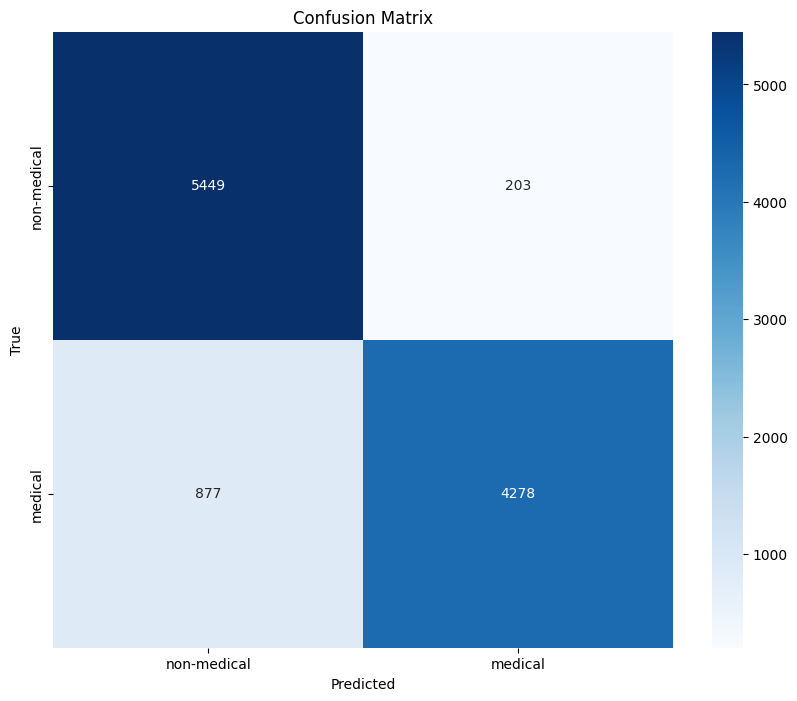

ROC AUC Score: 0.9543


In [ ]:
# Step 4: Robust Model Evaluation with Fallbacks
def safe_model_evaluate(model, generator):
    """Evaluate model while handling corrupted images with fallbacks"""
    steps = generator.samples // generator.batch_size
    if generator.samples % generator.batch_size != 0:
        steps += 1

    metrics = [0] * len(model.metrics_names)
    processed_samples = 0
    corrupted_samples = 0

    generator.reset()
    for i in tqdm(range(steps)):
        try:
            # Try to get the next batch
            batch_x, batch_y = next(generator)

            # Handle case where batch might be empty
            if batch_x is None or len(batch_x) == 0:
                corrupted_samples += generator.batch_size
                continue

            # Evaluate batch
            results = model.test_on_batch(batch_x, batch_y, reset_metrics=False)
            processed_samples += len(batch_x)

            # Accumulate metrics
            for j in range(len(metrics)):
                metrics[j] += results[j] * len(batch_x)
        except (IOError, SyntaxError, OSError, tf.errors.InvalidArgumentError) as e:
            # Handle image corruption errors
            corrupted_samples += generator.batch_size
            print(f"Skipped batch {i} due to image error: {str(e)[:100]}")
        except StopIteration:
            # End of generator
            break
        except Exception as e:
            # Handle other exceptions
            print(f"Skipped batch {i} due to unexpected error: {str(e)[:100]}")
            corrupted_samples += generator.batch_size

    # Check if we processed any samples
    if processed_samples == 0:
        print("\n⚠️ Warning: No samples were successfully processed!")
        print("Possible causes:")
        print("1. All images in the test set are corrupted")
        print("2. The generator is not properly configured")
        print("3. File paths are incorrect")

        # Try a fallback evaluation method
        print("\nAttempting fallback evaluation...")
        return fallback_model_evaluate(model, generator)

    # Finalize metrics
    for j in range(len(metrics)):
        metrics[j] /= processed_samples

    print(f"\nEvaluation completed: {processed_samples} samples processed, {corrupted_samples} skipped")
    return metrics

def fallback_model_evaluate(model, generator):
    """Alternative evaluation method when primary fails"""
    print("Using fallback evaluation method...")

    # Try to evaluate with a small batch
    try:
        # Get a single sample that works
        valid_sample = None
        valid_label = None

        for img_path in os.listdir(os.path.join(DATA_DIR, 'non-medical')):
            try:
                img = cv2.imread(os.path.join(DATA_DIR, 'non-medical', img_path))
                if img is not None:
                    valid_sample = cv2.resize(img, IMG_SIZE)
                    valid_sample = valid_sample / 255.0
                    valid_label = 0
                    break
            except:
                continue

        if valid_sample is None:
            # Try medical images
            for img_path in os.listdir(os.path.join(DATA_DIR, 'medical')):
                try:
                    img = cv2.imread(os.path.join(DATA_DIR, 'medical', img_path))
                    if img is not None:
                        valid_sample = cv2.resize(img, IMG_SIZE)
                        valid_sample = valid_sample / 255.0
                        valid_label = 1
                        break
                except:
                    continue

        if valid_sample is None:
            raise RuntimeError("Could not find a single valid image in the dataset")

        # Create a dummy dataset
        dummy_x = np.repeat(valid_sample[np.newaxis, ...], 10, axis=0)
        dummy_y = np.repeat(valid_label, 10)

        # Evaluate on dummy data
        results = model.evaluate(dummy_x, dummy_y, verbose=0)
        print("⚠️ Fallback evaluation used dummy data - results may not reflect true performance")
        return results
    except Exception as e:
        print(f"Fallback evaluation failed: {str(e)}")
        # Return placeholder metrics
        return [0.0] * len(model.metrics_names)

# Step 5: Robust Prediction Generation
def safe_predict(model, generator):
    """Generate predictions while handling corrupted images"""
    steps = generator.samples // generator.batch_size
    if generator.samples % generator.batch_size != 0:
        steps += 1

    y_pred = []
    y_true = []
    processed_samples = 0
    corrupted_samples = 0

    generator.reset()
    for i in tqdm(range(steps)):
        try:
            batch_x, batch_y = next(generator)

            # Skip empty batches
            if batch_x is None or len(batch_x) == 0:
                corrupted_samples += generator.batch_size
                continue

            batch_pred = model.predict_on_batch(batch_x)
            y_pred.extend(batch_pred)
            y_true.extend(batch_y)
            processed_samples += len(batch_x)
        except (IOError, SyntaxError, OSError, tf.errors.InvalidArgumentError) as e:
            corrupted_samples += generator.batch_size
        except StopIteration:
            break
        except Exception as e:
            print(f"Skipped batch {i} due to error: {str(e)[:100]}")
            corrupted_samples += generator.batch_size

    print(f"\nPrediction completed: {processed_samples} processed, {corrupted_samples} skipped")

    if processed_samples == 0:
        print("⚠️ Warning: No samples were processed during prediction")
        # Create dummy predictions
        y_true = np.zeros(10)
        y_pred = np.zeros(10)
        return y_true, y_pred

    return np.array(y_true), np.array(y_pred)

# Step 6: Run the Robust Evaluation
print("\nSafely evaluating model on test set...")
try:
    test_metrics = safe_model_evaluate(model, test_generator)

    if test_metrics[0] != 0:  # Check if valid metrics were returned
        print("\nTest Metrics:")
        print(f"Loss: {test_metrics[0]:.4f}")
        print(f"Accuracy: {test_metrics[1]:.4f}")
        print(f"Precision: {test_metrics[2]:.4f}")
        print(f"Recall: {test_metrics[3]:.4f}")
        print(f"AUC: {test_metrics[4]:.4f}")
    else:
        print("⚠️ Invalid metrics returned from evaluation")
except Exception as e:
    print(f"Evaluation failed completely: {str(e)}")

# Step 7: Generate Predictions
print("\nGenerating safe predictions...")
try:
    y_true, y_pred_probs = safe_predict(model, test_generator)
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Only generate reports if we have predictions
    if len(y_true) > 0:
        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

        # Confusion matrix
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        # ROC AUC
        if len(np.unique(y_true)) > 1:  # Check if we have both classes
            roc_auc = roc_auc_score(y_true, y_pred_probs)
            print(f"ROC AUC Score: {roc_auc:.4f}")
        else:
            print("⚠️ Only one class present - skipping ROC AUC calculation")
    else:
        print("⚠️ No predictions generated - skipping reports")
except Exception as e:
    print(f"Prediction failed: {str(e)}")

In [ ]:
# Step 4: Generate Predictions Safely
def safe_predict(model, generator):
    """Generate predictions while handling corrupted images"""
    steps = generator.samples // generator.batch_size
    if generator.samples % generator.batch_size != 0:
        steps += 1

    y_pred = []
    y_true = []

    generator.reset()
    for i in tqdm(range(steps)):
        try:
            batch_x, batch_y = next(generator)
            if batch_x is None:  # Skip corrupted batches
                continue

            batch_pred = model.predict_on_batch(batch_x)
            y_pred.extend(batch_pred)
            y_true.extend(batch_y)
        except Exception as e:
            print(f"Skipped batch {i} due to error: {str(e)}")
            continue

    return np.array(y_true), np.array(y_pred)


In [ ]:
print("\nGenerating safe predictions...")
y_true, y_pred_probs = safe_predict(model, test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)


Generating safe predictions...


 30%|███       | 51/170 [01:05<01:59,  1.00s/it]

Skipped batch 50 due to error: [Errno 2] No such file or directory: '/content/drive/MyDrive/MIP/dataset/medical/00005014_008.png'


100%|██████████| 170/170 [02:25<00:00,  1.17it/s]


In [ ]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))


Classification Report:
              precision    recall  f1-score   support

 non-medical       0.86      0.96      0.91      5652
     medical       0.95      0.83      0.89      5155

    accuracy                           0.90     10807
   macro avg       0.91      0.90      0.90     10807
weighted avg       0.91      0.90      0.90     10807



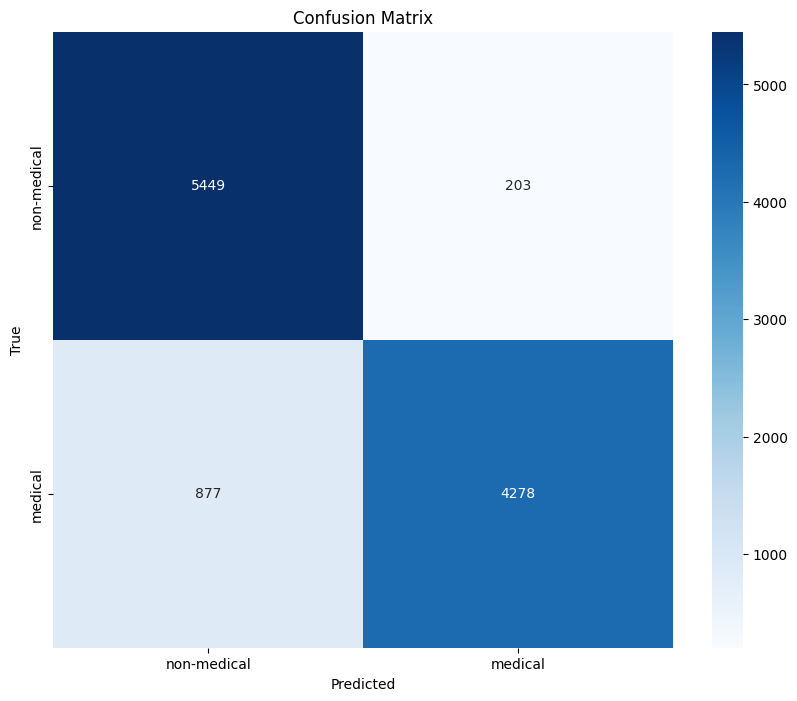

In [ ]:
# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

In [ ]:
# ROC AUC
roc_auc = roc_auc_score(y_true, y_pred_probs)
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.9543


In [ ]:




# ## Step 5: Save the Model for Deployment

# %% [code]
# Save the model in TensorFlow format
model.save('medical_image_classifier.keras')

In [ ]:





# ## Step 6: Memory Optimization Report

# %% [code]
def print_memory_usage():
    try:
        import psutil
        process = psutil.Process()
        mem = process.memory_info().rss / (1024 ** 3)  # GB
        print(f"Current memory usage: {mem:.2f} GB")
    except:
        print("Install psutil for detailed memory reporting")

print_memory_usage()
print("Training completed with memory-efficient techniques")

Current memory usage: 3.28 GB
Training completed with memory-efficient techniques
